In [31]:
# Core
import os
import pandas as pd
import numpy as np

# Viz (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Persistence
import joblib

# Speed mode
SPEED_MODE = True
RANDOM_STATE = 42


In [32]:
data_path = "dataset/train.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

df = pd.read_csv(data_path)

if "loan_paid_back" not in df.columns:
    raise ValueError("Target column 'loan_paid_back' missing")

# Encode target if categorical
if df["loan_paid_back"].dtype == "object":
    df["loan_paid_back"] = df["loan_paid_back"].map({"Yes": 1, "No": 0})

print("Shape:", df.shape)
print("Target distribution:\n", df["loan_paid_back"].value_counts(normalize=True))
df.head()


Shape: (593994, 13)
Target distribution:
 loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [33]:
df_clean = df.copy()

# Drop ID-like columns if present
for id_like in ["id", "ID", "Id"]:
    if id_like in df_clean.columns:
        df_clean = df_clean.drop(id_like, axis=1)

# Clip outliers on numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != "loan_paid_back":  # exclude target
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lb = Q1 - 1.5 * IQR
        ub = Q3 + 1.5 * IQR
        df_clean[col] = np.clip(df_clean[col], lb, ub)

print("Cleaned shape:", df_clean.shape)
print("Remaining columns:", df_clean.columns.tolist())


Cleaned shape: (593994, 12)
Remaining columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']


In [34]:
X = df_clean.drop("loan_paid_back", axis=1)
y = df_clean["loan_paid_back"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 loan_paid_back
1    379595
0     95600
Name: count, dtype: int64
Test class distribution:
 loan_paid_back
1    94899
0    23900
Name: count, dtype: int64


In [35]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
    ]
)


In [36]:
models = {
    "logistic": LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    "random_forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_STATE, n_iter_no_change=5, validation_fraction=0.1),
}

if SPEED_MODE:
    param_grids = {
        "logistic": {"clf__C": [0.1, 1]},
        "random_forest": {"clf__n_estimators": [100], "clf__max_depth": [10, None]},
        "gradient_boosting": {"clf__n_estimators": [100], "clf__learning_rate": [0.1]}
    }
    n_iter = 4
    n_splits = 3
else:
    param_grids = {
        "logistic": {"clf__C": [0.01, 0.1, 1, 10]},
        "random_forest": {"clf__n_estimators": [100, 200], "clf__max_depth": [10, 20, None]},
        "gradient_boosting": {"clf__n_estimators": [100, 200], "clf__learning_rate": [0.05, 0.1]}
    }
    n_iter = 10
    n_splits = 5

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)


In [37]:
pipelines = {}
for name, clf in models.items():
    pipelines[name] = Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", clf)
    ])


In [38]:
best_models = {}
best_params = {}
cv_scores = {}

for name in pipelines:
    print(f"Searching: {name}")
    search = RandomizedSearchCV(
        estimator=pipelines[name],
        param_distributions=param_grids[name],
        n_iter=n_iter,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    cv_scores[name] = search.best_score_
    print(f"Best CV accuracy ({name}): {search.best_score_:.4f}")
    print(f"Best params: {search.best_params_}\n")


Searching: logistic


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best CV accuracy (logistic): 0.8919
Best params: {'clf__C': 1}

Searching: random_forest


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best CV accuracy (random_forest): 0.9024
Best params: {'clf__n_estimators': 100, 'clf__max_depth': 10}

Searching: gradient_boosting


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best CV accuracy (gradient_boosting): 0.9031
Best params: {'clf__n_estimators': 100, 'clf__learning_rate': 0.1}



Selected best model: gradient_boosting
Train Accuracy: 0.9033007502183314
Test Accuracy: 0.9029200582496486

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.59      0.71     23900
           1       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799



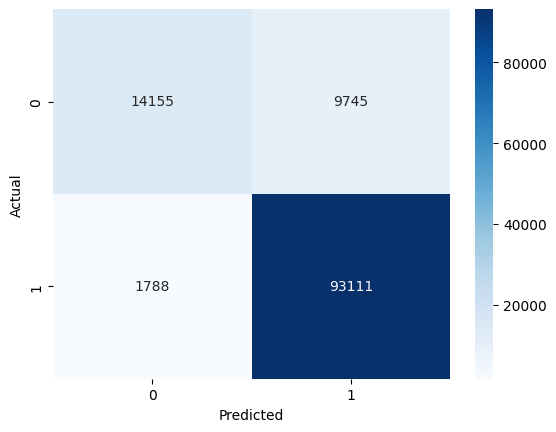

In [39]:
best_model_name = max(cv_scores, key=cv_scores.get)
best_model = best_models[best_model_name]

print(f"Selected best model: {best_model_name}")

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
joblib.dump(best_model, "best_pipeline.pkl")
joblib.dump({
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "all_feature_columns": X.columns.tolist(),
    "best_model_name": best_model_name,
    "best_params": best_params[best_model_name],
    "speed_mode": SPEED_MODE
}, "pipeline_meta.pkl")

print("Saved: best_pipeline.pkl and pipeline_meta.pkl")


Saved: best_pipeline.pkl and pipeline_meta.pkl
